# Beams - structural beams

This notebook shows how to use Beam elements model cantilever beams, how to get the results and how those results compare to theory.

A "Beam" in DAVE consists of a number of discrete segments and has a different formulation than the beams typically found in FEM packages.

In [18]:
from DAVE import *
s = Scene();

Beams are elastic nodes that can be created between axis systems.

In [19]:
left = s.new_frame("left")
right = s.new_frame("right", position = (5,0,0)) # position is not needed, it will be solved
beam = s.new_beam("beam", nodeA=left, nodeB = right,
                        EA = 1000,
                        EIy = 1e5, EIz = 1e5, GIp = 1e3,
                        L=10,
                        mass = 0,
                        n_segments=20)
right.set_free()
s.solve_statics();

In [20]:
from DAVE.jupyter import *;

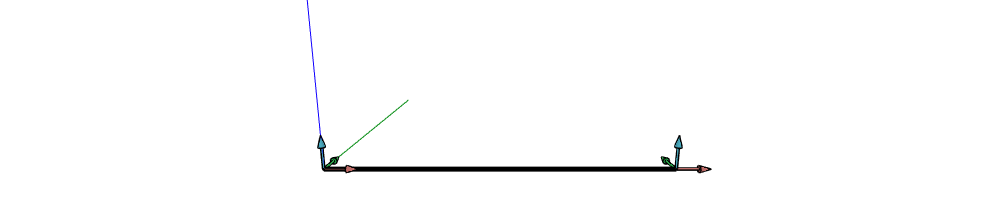

In [21]:
show(s, camera_pos=(5,-10,4), lookat = (5,0,2), width=1000, height = 200)

A Beam node is rigidly fixed to the axis systems at its ends. It is fixed in the positive X-direction, so it departs from node A along the X-axis and arrives at ndoe B from the negative X-direction.

At the momement we have a massless beam with its left side fixed (`Frame` "left" is fixed) and its right size free (the right end of the beam is fixed to `Frame` "right", but "right" is not connected to anything and is free to move).

This is one of those cases that frequently occur in textbooks and for which we can easily check the results.

![cantilever.png](cantilever.png)

First place a point on the right side so that we can apply a force:

In [22]:
s.new_point("point", parent = right)
force = s.new_force("force", parent = "point")

### Cantilever beam with a force

In [23]:
force.force = (0,0,-100)

In [24]:
s.solve_statics()

True

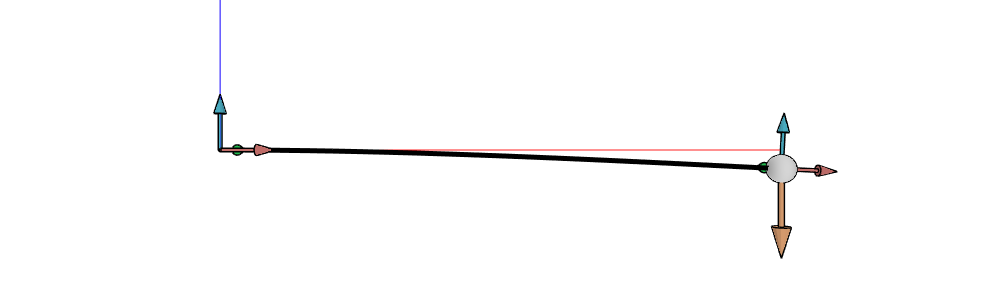

In [25]:
show(s, camera_pos=(5,-10,0), lookat = (5,0,0), width=1000, height = 300)

Theory tells us that the deflection and rotation of the right end should be:

$\delta = -PL^3 / 3EI$

and

$\Theta = PL^2 / 2EI$

Get the values from the model:

In [26]:
L = beam.L
EI = beam.EIy
P = -force.force[2]

And calculate their values

The deflection is the vertical displacement of the axis system on the right side of the beam:

In [27]:
right.z

-0.33604653085525665

In [28]:
-P*L**3 / (3*EI)

-0.3333333333333333

Theta is the slope. The slope can be calculated from the rotation of the axis system, but it is also available as "tilt", which is a percentage.

In [29]:
right.tilt_y / 100

0.05014161613346104

In [30]:
P*L**2 / (2*EI)

0.05

It is also possible to obtain the forces in the beam.

The moments are available at the nodes.

In [31]:
import matplotlib.pyplot as plt

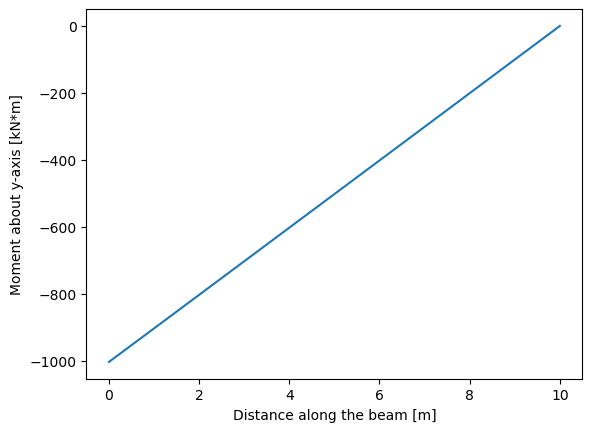

In [32]:
plt.plot(beam.X_nodes, beam.bending[:,1])
plt.xlabel('Distance along the beam [m]')
plt.ylabel('Moment about y-axis [kN*m]');

## Cantilever with moment

We can do the same with a moment

In [33]:
force.force = (0,0,0)
force.moment = (0,1000,0)

In [34]:
s.solve_statics()

True

c:\python\miniconda3\envs\book\Lib\site-packages\DAVE\visual_helpers\vtkHelpers.py:604: RuntimeWarning: invalid value encountered in divide
  axis = axis / length


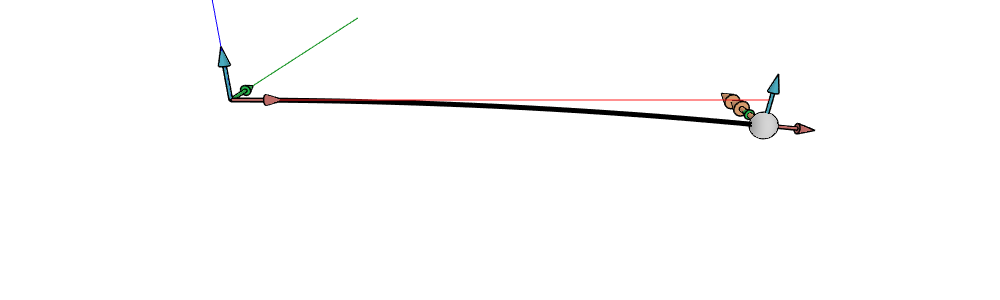

In [35]:
show(s, camera_pos=(5,-10,3), lookat = (5,0,-1), width=1000, height = 300)

Theory tells us that the deflection and rotation of the right end should be:

$\delta = ML^2 / 2EI$

and

$\Theta = ML / EI$

Get the values from the model:

In [36]:
M = force.moment[1]  # moment about Y-axis

In [37]:
M*L**2 / (2*EI)

0.5

In [38]:
-right.z

0.4995839926912043

In [39]:
M*L / EI

0.1

In [40]:
right.tilt_y / 100

0.09983341666017789

## Tension and torsion

Beam can also take tension and torsion.

In [41]:
force.force = (100,0,0)
force.moment = (100,0,0)

In [42]:
s.solve_statics()

True

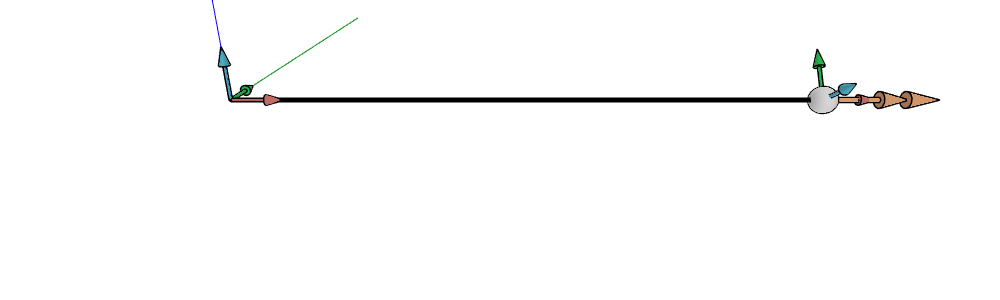

In [43]:
show(s, camera_pos=(5,-10,3), lookat = (5,0,-1), width=1000, height = 300)

Tension and torsion forces in the beam are available not at the nodes but at the centers for the beam segments.

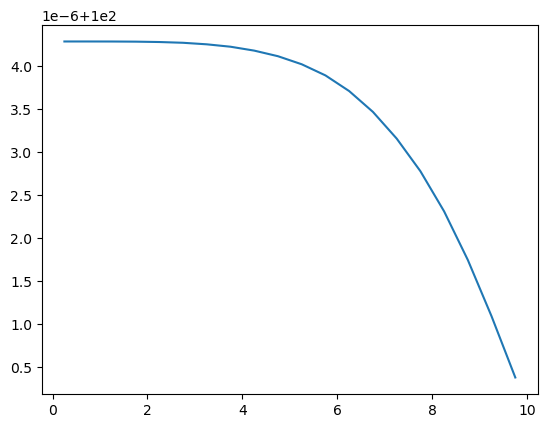

In [44]:
plt.plot(beam.X_midpoints, beam.torsion);

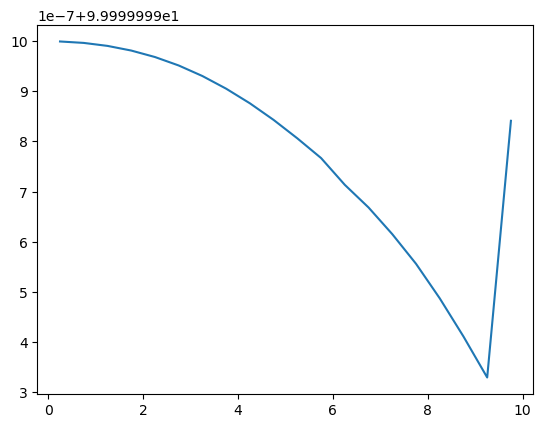

In [45]:
plt.plot(beam.X_midpoints, beam.tension);

**Now this looks horrible!** 

Fortunately this is just the way matplotlib displays data which is almost constant.

Looking at the data directly it appears to be comfortingly constant:

In [46]:
beam.torsion

[100.00000428455166,
 100.0000042844949,
 100.00000428415083,
 100.00000428256237,
 100.00000427823248,
 100.00000426935706,
 100.00000425146958,
 100.00000422352096,
 100.0000041781012,
 100.00000411295771,
 100.00000401930589,
 100.00000388960666,
 100.00000370725613,
 100.00000346510011,
 100.00000315492589,
 100.00000277518465,
 100.00000230732795,
 100.0000017412424,
 100.00000108571953,
 100.00000037367465]

In [47]:
import matplotlib
matplotlib.rcParams['axes.formatter.useoffset'] = False

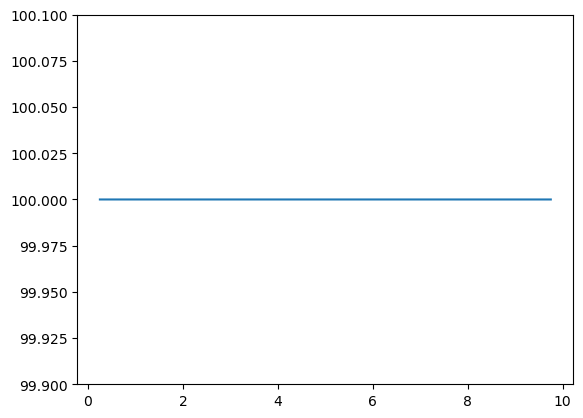

In [48]:
plt.plot(beam.X_midpoints, beam.torsion);
plt.ylim((99.9, 100.1));

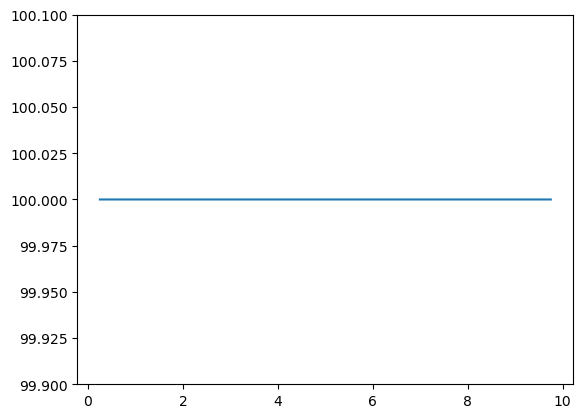

In [49]:
plt.plot(beam.X_midpoints, beam.tension);
plt.ylim((99.9, 100.1));

## Distributed load

Modelling a distributed load is not possible in this way. Loads can only be added at points.

To model a distributed load we would have to manually discretise the model and add discrete loads at each node.

But these is a shortcut that we can take: The beams can have a mass. We can use the mass to model a distributed load as gravity.

In [50]:
s.delete('force')

In [51]:
q = 10 # kN/m

In [52]:
beam.mass = beam.L * q  / 9.81

In [53]:
s.solve_statics()

True

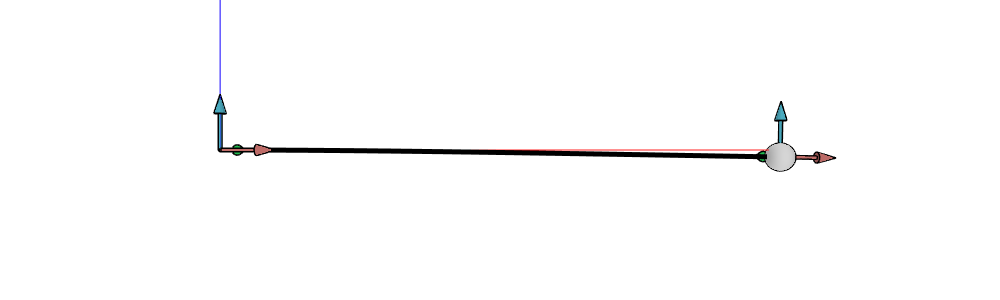

In [54]:
show(s, camera_pos=(5,-10,0), lookat = (5,0,0), width=1000, height = 300)

Theory tells us that the deflection and rotation of the right end should be:

$\delta = qL^4 / 8EI$

and

$\Theta = qL^3 / 6EI$

In [55]:
-q*L**4 / (8*EI)

-0.125

In [56]:
right.z

-0.1253934069731925

In [57]:
q*L**3 / (6*EI)

0.016666666666666666

In [58]:
right.tilt_y / 100

0.016689374861200167

## Large deflections

All the tests done so far were performed on small deflections. That is for a good reason. The Euler/Bernouilli beam theory is only applicable to small displacements. This is because in this theory the moment is derived from the deflection:

$d^2/dx^2(EI d^2w / dx^2) = q$

so the moment in the beam is proprtional to the change in slope. This is only valid for small changes.

The implementation in DAVE **is valid for large deflections**, it is just that the analytical formula used above are not.

## Number of segments

Beams use a discrete model (see theory https://davedocs.online/beams.html).

When a higher number of segments is used:
- The model become more accurate
- The solver becomes slower 
- (The numerical errors build up)

So the number of nodes should be selected with some caution. In general 20 seems to be a good number for beams although in some cases (for example pure tension or torsion) a single segment is just as good.

It is easy to use the "plot_effect" function in scene to check the effect of the number of segments.

Here we calculate the effect of the number of segments on the vertical position of the second end of the beam:

setting 1.0 results in -0.2504354072837573
setting 2.0 results in -0.15639089332981548
setting 3.0 results in -0.1389910434502611
setting 4.0 results in -0.13290403867719833
setting 5.0 results in -0.1300872329757714
setting 6.0 results in -0.1285572568518122
setting 7.0 results in -0.12763479900485464
setting 8.0 results in -0.12703611080260366
setting 9.0 results in -0.12662566273433065
setting 10.0 results in -0.12633207552412554
setting 11.0 results in -0.1261148602975285
setting 12.0 results in -0.1259496505139831
setting 13.0 results in -0.12582107945580853
setting 14.0 results in -0.1257190628826018
setting 15.0 results in -0.12563676152024328
setting 16.0 results in -0.1255694041610991
setting 17.0 results in -0.12551358025912016
setting 18.0 results in -0.12546679927827994
setting 19.0 results in -0.12542720748932626
setting 20.0 results in -0.12539340734702664
setting 21.0 results in -0.12536431820362948
setting 22.0 results in -0.12533910507802803
setting 23.0 results in -0.

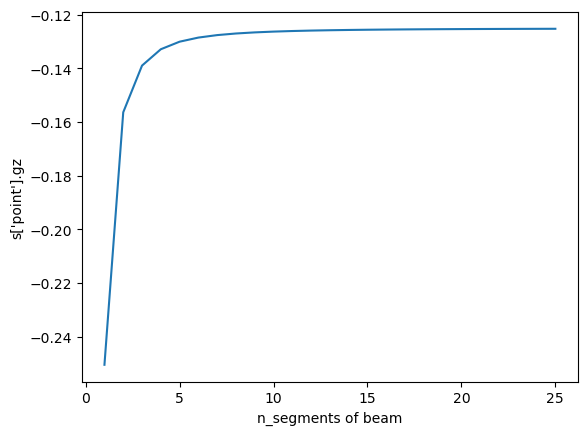

In [59]:
s.plot_effect(evaluate="s['point'].gz",
   change_property="n_segments",
    change_node="beam",
    start=1,
    to=25.0,
    steps=25);

-- end --